In [1]:
import matplotlib.pyplot as plt

import numpy as np
import scipy.special
import plotly.graph_objects as go

In [2]:
def gto_sigma(cutoff, n, n_max):
    """
    Compute GTO sigma

    ---Arguments---
    cutoff: environment cutoff
    n: order of the GTO
    n_max: maximum order of the GTO

    ---Returns---
    sigma: GTO sigma parameter
    """
    return np.maximum(np.sqrt(n), 1) * cutoff / n_max


def gto_width(sigma):
    """
    Compute GTO width

    ---Arguments---
    sigma: GTO sigma parameter

    ---Returns---
    b: GTO (Gaussian) width
    """
    return 1.0 / (2 * sigma**2)


def gto_prefactor(n, sigma):
    """
    Compute GTO prefactor

    ---Arguments---
    n: order of the GTO
    sigma: GTO sigma parameter

    ---Returns---
    N: GTO prefactor (normalization factor)
    """
    return np.sqrt(2 / (sigma ** (2 * n + 3) * scipy.special.gamma(n + 1.5)))


def gto(r, n, sigma):
    """
    Compute GTO

    ---Arguments---
    r: grid on which to evaluate the GTO
    n: order of the GTO
    sigma: GTO sigma parameter

    ---Returns---
    R_n: GTO of order n evaluated on the provided grid
    """
    b = gto_width(sigma)
    N = gto_prefactor(n, sigma)
    return N * r ** (n + 1) * np.exp(-b * r**2)


def gto_overlap(n, m, sigma_n, sigma_m):
    """
    Compute overlap of two GTOs

    ---Arguments---
    n: order of the first GTO
    m: order of the second GTO
    sigma_n: sigma parameter of the first GTO
    sigma_m: sigma parameter of the second GTO

    ---Returns---
    S: overlap of the two GTOs
    """
    b_n = gto_width(sigma_n)
    b_m = gto_width(sigma_m)
    N_n = gto_prefactor(n, sigma_n)
    N_m = gto_prefactor(m, sigma_m)
    nm = 0.5 * (3 + n + m)
    return 0.5 * N_n * N_m * (b_n + b_m) ** (-nm) * scipy.special.gamma(nm)


def gto_S(hypers):
    """
    Compute the GTO overlap

    ---Arguments---
    hypers: dictionary of SOAP hyperparameters
    r_grid: grid of radial distances on which to evaluate the GTOs

    ---Returns---
    R_n: orthogonalized GTOs evaluated on `r_grid`
    """

    # Setup grids of the expansion orders
    n_grid = np.arange(0, hypers["max_radial"])
    sigma_grid = gto_sigma(hypers["interaction_cutoff"], n_grid, hypers["max_radial"])

    # Compute radial normalization factor based on the GTO overlap
    S = gto_overlap(
        n_grid[:, np.newaxis],
        n_grid[np.newaxis, :],
        sigma_grid[:, np.newaxis],
        sigma_grid[np.newaxis, :],
    )
    return S


def radial_basis_functions_gto(radial_grid, max_radial, cutoff):
    """
    Evaluate GTO radial basis function for R_n on a grid.
    These are equivalent to the basis used to expand the density in the
    librascal GTO implementation.

    radial_grid : array_like
        R_n is evaluated on the grid (0, r_c + 3 * σ]

    max_radial : int
        max_radial in rascal

    cutoff : float

    Returns:
    -------
    R_n : array_like
        R_n is evaluated on the `radial_grid`
    """

    # Setup grids of the expansion orders
    n_grid = np.arange(0, max_radial)
    sigma_grid = gto_sigma(cutoff, n_grid, max_radial)

    # Compute radial normalization factor based on the GTO overlap
    S = gto_overlap(
        n_grid[:, np.newaxis],
        n_grid[np.newaxis, :],
        sigma_grid[:, np.newaxis],
        sigma_grid[np.newaxis, :],
    )
    # Computes S^{-1/2} to orthogonalize the GTOs
    eva, eve = np.linalg.eigh(S)
    S = eve @ np.diag(1 / np.sqrt(eva)) @ eve.T

    # Compute GTOs, shape (n_max, len(r_grid))
    R_n = np.matmul(
        S,
        gto(
            radial_grid[np.newaxis, :], n_grid[:, np.newaxis], sigma_grid[:, np.newaxis]
        ),
    )

    return R_n

In [3]:
cutoff = 3.5

grid = np.arange(0, cutoff, 0.01)

gto_basis = radial_basis_functions_gto(grid, max_radial=12, cutoff=cutoff)

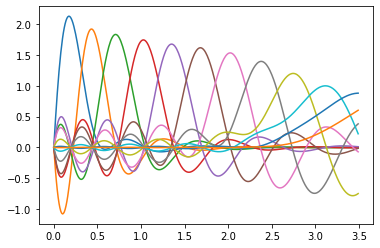

In [4]:
for g in gto_basis:
    plt.plot(grid, g)

In [5]:
ATOM_PER_SPECIES = {
    1: "H",
    2: "He",
    3: "Li",
    4: "Be",
    5: "B",
    6: "C",
    7: "N",
    8: "O",
    9: "F",
    10: "Ne",
    11: "Na",
    12: "Mg",
    13: "Al",
    14: "Si",
    15: "P",
    16: "S",
    17: "Cl",
    18: "Ar",
    19: "K",
    20: "Ca",
    21: "Sc",
    22: "Ti",
    23: "V",
    24: "Cr",
    25: "Mn",
    26: "Fe",
    27: "Co",
    28: "Ni",
    29: "Cu",
    30: "Zn",
    31: "Ga",
    32: "Ge",
    33: "As",
    34: "Se",
    35: "Br",
    36: "Kr",
    37: "Rb",
    38: "Sr",
    39: "Y",
    40: "Zr",
    41: "Nb",
    42: "Mo",
    43: "Tc",
    44: "Ru",
    45: "Rh",
    46: "Pd",
    47: "Ag",
    48: "Cd",
    49: "In",
    50: "Sn",
    51: "Sb",
    52: "Te",
    53: "I",
    54: "Xe",
    55: "Cs",
    56: "Ba",
    57: "La",
    58: "Ce",
    59: "Pr",
    60: "Nd",
    61: "Pm",
    62: "Sm",
    63: "Eu",
    64: "Gd",
    65: "Tb",
    66: "Dy",
    67: "Ho",
    68: "Er",
    69: "Tm",
    70: "Yb",
    71: "Lu",
    72: "Hf",
    73: "Ta",
    74: "W",
    75: "Re",
    76: "Os",
    77: "Ir",
    78: "Pt",
    79: "Au",
    80: "Hg",
    81: "Tl",
    82: "Pb",
    83: "Bi",
    84: "Po",
    85: "At"
}

In [6]:
import json
import os
import sys
import time
from datetime import datetime

import ase.io
import numpy as np
import torch

from utils.combine import CombineSpecies, CombineRadialSpecies
from utils.dataset import AtomisticDataset, create_dataloader
from utils.model import AlchemicalModel


torch.set_default_dtype(torch.float64)


def loss_mae(predicted, actual):
    return torch.sum(torch.abs(predicted.flatten() - actual.flatten()))


def loss_mse(predicted, actual):
    return torch.sum((predicted.flatten() - actual.flatten()) ** 2)


def loss_rmse(predicted, actual):
    return np.sqrt(loss_mse(predicted, actual))


def extract_energy_forces(frames):
    energies = (
        torch.tensor([frame.info["energy"] for frame in frames])
        .reshape(-1, 1)
        .to(dtype=torch.get_default_dtype())
    )

    forces = [
        torch.tensor(frame.arrays["forces"]).to(dtype=torch.get_default_dtype())
        for frame in frames
    ]

    return energies, forces

In [7]:
device = "cpu"
# folder = "example_ts_3000_lr_01_ncb_16_mr_12_220926-1513"
folder = "example_check_density_changes"
# datafile = "data/data_shuffle.xyz"
# datafile = "data/qm7-chno.xyz"
datafile = "data/data_test.xyz"
with open(folder + "/parameters.json") as fd:
    parameters = json.load(fd)
# --------- READING STUFF --------- #
print("Reading file and properties")
# n_test = parameters["n_test"]
# n_train = parameters["n_train"]
n_test = 1
n_train = 1
n_train_forces = parameters["n_train_forces"]
frames = ase.io.read(datafile, ":")
all_species = set()
for frame in frames:
    all_species.update(frame.numbers)
all_species = list(map(lambda u: int(u), all_species))
print("All species ", all_species)
train_frames = frames[:n_train]
train_forces_frames = frames[n_train : n_train + n_train_forces]
test_frames = frames[-n_test:]
train_energies, _ = extract_energy_forces(train_frames)
train_f_energies, train_f_forces = extract_energy_forces(train_forces_frames)
test_energies, test_forces = extract_energy_forces(test_frames)
print(
    f"using {n_train} training frames and {n_train_forces} training "
    "frames with forces"
)
print("Computing representations")
hypers_ps = parameters["hypers_ps"]
if "radial_per_angular" in hypers_ps:
    hypers_ps["radial_per_angular"] = {
        int(k): v for k, v in hypers_ps["radial_per_angular"].items()
    }
hypers_rs = parameters.get("hypers_rs")
train_dataset = AtomisticDataset(
    train_frames,
    all_species,
    {"radial_spectrum": hypers_rs, "spherical_expansion": hypers_ps},
    train_energies,
)
if n_train_forces != 0:
    train_forces_dataset_grad = AtomisticDataset(
        train_forces_frames,
        all_species,
        {"radial_spectrum": hypers_rs, "spherical_expansion": hypers_ps},
        train_f_energies,
        train_f_forces,
        do_gradients=True,
    )
else:
    train_forces_dataset_grad = None
test_dataset_grad = AtomisticDataset(
    test_frames,
    all_species,
    {"radial_spectrum": hypers_rs, "spherical_expansion": hypers_ps},
    test_energies,
    test_forces,
    do_gradients=True,
)
# --------- DATA LOADERS --------- #
print("Creating data loaders")
train_dataloader_no_batch = create_dataloader(
    train_dataset,
    batch_size=len(train_dataset),
    shuffle=False,
    device=device,
)
train_dataloader_single_frame = create_dataloader(
    train_dataset,
    batch_size=1,
    shuffle=False,
    device=device,
)
if n_train_forces != 0:
    train_forces_dataloader_grad_no_batch = create_dataloader(
        train_forces_dataset_grad,
        batch_size=len(train_forces_dataset_grad),
        shuffle=False,
        device=device,
    )
else:
    train_forces_dataloader_grad_no_batch = None
test_dataloader_grad = create_dataloader(
    test_dataset_grad,
    batch_size=50,
    shuffle=False,
    device=device,
)
# combiner = CombineSpecies(
#     species=all_species,
#     n_pseudo_species=parameters["n_pseudo_species"],
#     # TODO: remove this from code
#     per_l_max=0,
# )

combiner = CombineRadialSpecies(
    n_species=len(all_species),
    max_radial=hypers_ps["max_radial"],
    n_combined_basis=parameters.get("n_combined_basis", 16)
)

COMPOSITION_REGULARIZER = parameters.get("composition_regularizer")
RADIAL_SPECTRUM_REGULARIZER = parameters.get("radial_spectrum_regularizer")
POWER_SPECTRUM_REGULARIZER = parameters.get("power_spectrum_regularizer")
NN_REGULARIZER = parameters.get("nn_regularizer")
FORCES_LOSS_WEIGHT = parameters.get("forces_loss_weight")
model = AlchemicalModel(
    combiner=combiner,
    composition_regularizer=COMPOSITION_REGULARIZER,
    radial_spectrum_regularizer=RADIAL_SPECTRUM_REGULARIZER,
    power_spectrum_regularizer=POWER_SPECTRUM_REGULARIZER,
    nn_layer_size=parameters.get("nn_layer_size"),
    # TODO: remove from code?
    ps_center_types=None,
)
model.to(device=device, dtype=torch.get_default_dtype())
# --------- INITIALIZE MODEL --------- #
print("Initializing model")
with torch.no_grad():
    for (
        composition,
        radial_spectrum,
        spherical_expansions,
        energies,
        forces,
    ) in train_dataloader_single_frame:
        model.initialize_model_weights(
            composition,
            radial_spectrum,
            spherical_expansions,
            energies,
            forces,
            seed=parameters.get("seed"),
        )
        break

del radial_spectrum, spherical_expansions

Reading file and properties
All species  [39, 72, 41, 40, 74, 78, 21, 23, 24, 27, 29]
using 1 training frames and 0 training frames with forces
Computing representations
Creating data loaders
Initializing model


In [8]:
n_parameters = sum(
    len(p.detach().cpu().numpy().flatten()) for p in model.parameters()
)
print(f"Model parameters: {n_parameters}")
for name, param in model.named_parameters():
    print(f"{name}, {param.detach().cpu().numpy().shape}")

try:
    state = torch.load(folder + "/best.torch")
    print("Restarting model parameters from file")
    model.load_state_dict(state)
except FileNotFoundError:
    print("Restart file not found")

Model parameters: 4531
composition_model.weights, (11, 1)
power_spectrum.combiner.combining_matrix, (242, 10)
power_spectrum_model.weights, (2100, 1)
Restart file not found


In [9]:
high_mem = True
if high_mem:
    composition, radial_spectrum, spherical_expansions, energies, forces = next(
        iter(train_dataloader_no_batch)
    )
    del train_dataset

In [10]:
# (i, lm, a*n)
for b in spherical_expansions.blocks():
    print(b.values.shape)

torch.Size([4, 1, 242])
torch.Size([4, 3, 242])
torch.Size([4, 5, 242])
torch.Size([4, 7, 242])
torch.Size([4, 9, 242])
torch.Size([4, 11, 242])
torch.Size([4, 13, 242])
torch.Size([4, 15, 242])
torch.Size([4, 17, 242])
torch.Size([4, 19, 242])
torch.Size([4, 21, 242])
torch.Size([4, 23, 242])
torch.Size([4, 25, 242])
torch.Size([4, 27, 242])
torch.Size([4, 29, 242])
torch.Size([4, 31, 242])
torch.Size([4, 33, 242])
torch.Size([4, 35, 242])
torch.Size([4, 37, 242])
torch.Size([4, 39, 242])
torch.Size([4, 41, 242])


In [11]:
# Cu, Zn, Sc, V
all_species, list(map(lambda x: ATOM_PER_SPECIES[x], all_species))

([39, 72, 41, 40, 74, 78, 21, 23, 24, 27, 29],
 ['Y', 'Hf', 'Nb', 'Zr', 'W', 'Pt', 'Sc', 'V', 'Cr', 'Co', 'Cu'])

In [12]:
# all_species
spherical_expansions.blocks()[0].properties

Labels([(39,  0), (39,  1), (39,  2), (39,  3), (39,  4), (39,  5),
        (39,  6), (39,  7), (39,  8), (39,  9), (39, 10), (39, 11),
        (39, 12), (39, 13), (39, 14), (39, 15), (39, 16), (39, 17),
        (39, 18), (39, 19), (39, 20), (39, 21), (72,  0), (72,  1),
        (72,  2), (72,  3), (72,  4), (72,  5), (72,  6), (72,  7),
        (72,  8), (72,  9), (72, 10), (72, 11), (72, 12), (72, 13),
        (72, 14), (72, 15), (72, 16), (72, 17), (72, 18), (72, 19),
        (72, 20), (72, 21), (41,  0), (41,  1), (41,  2), (41,  3),
        (41,  4), (41,  5), (41,  6), (41,  7), (41,  8), (41,  9),
        (41, 10), (41, 11), (41, 12), (41, 13), (41, 14), (41, 15),
        (41, 16), (41, 17), (41, 18), (41, 19), (41, 20), (41, 21),
        (40,  0), (40,  1), (40,  2), (40,  3), (40,  4), (40,  5),
        (40,  6), (40,  7), (40,  8), (40,  9), (40, 10), (40, 11),
        (40, 12), (40, 13), (40, 14), (40, 15), (40, 16), (40, 17),
        (40, 18), (40, 19), (40, 20), (40, 21), 

In [13]:
np.argwhere(np.array(list(map(lambda x: ATOM_PER_SPECIES[x], all_species))) == "Cu").flatten()[0]

10

In [14]:
# take Cu as i, Zn as alpha
# i = 1 # Cu
# alpha = 2 # Zn
# i = np.argwhere(np.array(list(map(lambda x: ATOM_PER_SPECIES[x], all_species))) == "Cu").flatten()[0]
i = 0
alpha = np.argwhere(np.array(list(map(lambda x: ATOM_PER_SPECIES[x], all_species))) == "Nb").flatten()[0]
# alpha = 2
print(f"i = {i}, alpha = {alpha}")
neighbor_data = []
n_max = hypers_ps["max_radial"]
for b in spherical_expansions.blocks():
    # for i, j in enumerate(b.values[1]):
    neighbor_data.append(np.copy(b.values[i, :, alpha*n_max:(alpha+1)*n_max]))
    
    # print(b.values[0, 0, :])
    # print(b.values[0, 0, 10:20])
    # neighbor_data.append(np.copy(b.values[0, 0, :]))
        # neighbor_data.append([i, np.copy(j[10:15])])

    # neighbor_data.append(np.allclose(b.values, np.zeros_like(b.values)))
neighbor_data[0]

i = 0, alpha = 2


array([[ 1.06055168e-07, -1.84747399e-07,  7.37537929e-08,
         1.21585159e-06, -5.86484859e-06,  8.47956885e-06,
         1.91295823e-05,  4.99871021e-06,  1.72803437e-05,
         2.02025274e-06,  1.86611618e-05, -6.97590760e-07,
         4.29554461e-06,  3.14341903e-07, -2.46913824e-06,
         3.81180322e-06, -3.86758433e-06,  2.85896611e-06,
        -1.55751923e-06,  5.97195550e-07, -1.44317246e-07,
         1.69851925e-08]])

In [15]:
[np.all(nn == 0.) for nn in neighbor_data]

[False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False]

In [16]:
def plot_block_list(block_list, xyz, cutoff=4):
    l_max = len(block_list) - 1
    n_max = block_list[0].shape[-1]

    radius = np.sqrt(xyz[0]**2 + xyz[1]**2 + xyz[2]**2)
    theta = np.arccos(xyz[2] / radius)
    phi = (np.arccos(xyz[0] / np.sqrt(xyz[0]**2 + xyz[1]**2)))
    phi*= (xyz[1] >= 0.) - 1*(xyz[1] < 0.)

    gto_b = radial_basis_functions_gto(radius.flatten(), max_radial=n_max, cutoff=cutoff).reshape(n_max, *radius.shape)
    values = np.zeros(radius.shape, dtype='complex128')
    
    for l in range(0, l_max+1):
        for i_m, m in enumerate(range(-l, l+1)):
            Y = scipy.special.sph_harm(abs(m), l, phi, theta)
            if m < 0:
                Y = np.sqrt(2) * (-1)**m * Y.imag
            elif m > 0:
                Y = np.sqrt(2) * (-1)**m * Y.real
            for n in range(0, n_max):
                values+= block_list[l][i_m, n] * Y * gto_b[n]
    values = np.abs(values)

    fig = go.Figure(data=go.Volume(
        x=xyz[0].flatten(),
        y=xyz[1].flatten(),
        z=xyz[2].flatten(),
        value=values.flatten(),
        opacity=0.1, # needs to be small to see through all surfaces
        surface_count=20, # needs to be a large number for good volume rendering
        ))
    fig.show()

In [20]:
xyz = np.mgrid[-1:6:20j, -1:6:20j, -1:6:20j]
plot_block_list(neighbor_data, xyz, cutoff=hypers_ps["cutoff"])

In [53]:
def loss_mae(predicted, actual):
    return torch.sum(torch.abs(predicted.flatten() - actual.flatten()))

class ModelTemp(torch.nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(2)
        self.w = torch.nn.Parameter(torch.rand((3,)))
        self.matrix = torch.rand((4,3))
        # self.vector = torch.rand((4,3)) @ torch.diag(self.w)

    def forward(self, x):
        vector = self.matrix @ torch.diag(self.w)
        return vector.T @ x

model_temp = ModelTemp()
optimizer = torch.optim.SGD(model_temp.parameters(), lr=0.05)
X_t, y_t = torch.rand(4,10), torch.rand(3,10)
for i in range(10):
    optimizer.zero_grad()
    p = model_temp(X_t)
    loss = loss_mae(p, y_t)
    print(f"epoch {i} loss = {loss.item()}")
    # loss.backward(retain_graph=False)
    loss.backward(retain_graph=True)
    optimizer.step()



epoch 0 loss = 12.521539141143364
epoch 1 loss = 9.552026303194395
epoch 2 loss = 9.01146919458359
epoch 3 loss = 8.828519331229625
epoch 4 loss = 8.513910966348982
epoch 5 loss = 9.164596400073323
epoch 6 loss = 9.292632213062994
epoch 7 loss = 8.844829220692274
epoch 8 loss = 8.467064490024143
epoch 9 loss = 9.259162287280043


In [ ]:
# xyz = np.mgrid[-3:3:30j, -3:3:30j, -3:3:30j]

# plot_block_list(neighbor_data, xyz, cutoff=hypers_ps["cutoff"])

In [20]:
arr = np.array([1, 0.1, 0.5, -1, -0.1, -0.5])
arr * (arr >= 0.) + (2 + arr) * (arr < 0.)
np.arccos(0.5)

1.0471975511965979

In [182]:
xyz = np.mgrid[-3:3:30j, -3:3:30j, -3:3:30j]
arr = np.zeros(xyz.size)
# arr.shape
# arr = arr.reshape(*xyz.shape[:-2], -1)
# arr.shape
# xyz[0] >= 0

(xyz[1] >= 0.) - 1*(xyz[1] < 0.)

array([[[-1, -1, -1, ..., -1, -1, -1],
        [-1, -1, -1, ..., -1, -1, -1],
        [-1, -1, -1, ..., -1, -1, -1],
        ...,
        [ 1,  1,  1, ...,  1,  1,  1],
        [ 1,  1,  1, ...,  1,  1,  1],
        [ 1,  1,  1, ...,  1,  1,  1]],

       [[-1, -1, -1, ..., -1, -1, -1],
        [-1, -1, -1, ..., -1, -1, -1],
        [-1, -1, -1, ..., -1, -1, -1],
        ...,
        [ 1,  1,  1, ...,  1,  1,  1],
        [ 1,  1,  1, ...,  1,  1,  1],
        [ 1,  1,  1, ...,  1,  1,  1]],

       [[-1, -1, -1, ..., -1, -1, -1],
        [-1, -1, -1, ..., -1, -1, -1],
        [-1, -1, -1, ..., -1, -1, -1],
        ...,
        [ 1,  1,  1, ...,  1,  1,  1],
        [ 1,  1,  1, ...,  1,  1,  1],
        [ 1,  1,  1, ...,  1,  1,  1]],

       ...,

       [[-1, -1, -1, ..., -1, -1, -1],
        [-1, -1, -1, ..., -1, -1, -1],
        [-1, -1, -1, ..., -1, -1, -1],
        ...,
        [ 1,  1,  1, ...,  1,  1,  1],
        [ 1,  1,  1, ...,  1,  1,  1],
        [ 1,  1,  1, ...,  1,  1

In [ ]:
def plot_F(n, l, m, xyz, cutoff=4):
    radius = np.sqrt(xyz[0]**2 + xyz[1]**2 + xyz[2]**2)
    theta = np.arccos(xyz[2] / radius)
    phi = (np.arccos(xyz[0] / np.sqrt(xyz[0]**2 + xyz[1]**2))).flatten()
    phi = phi * (xyz[1].flatten() >= 0.) + (2*np.pi - phi) * ~(xyz[1].flatten() >= 0.)
    phi = phi.reshape(radius.shape)

    gto_b = radial_basis_functions_gto(radius.flatten(), max_radial=n, cutoff=cutoff)[-1].reshape(radius.shape)
    
    Y = scipy.special.sph_harm(abs(m), l, phi, theta)
    if m < 0:
        Y = np.sqrt(2) * (-1)**m * Y.imag
    elif m > 0:
        Y = np.sqrt(2) * (-1)**m * Y.real
    # values = np.abs(Y) * np.exp(-radius**2)
    # values = Y.real * np.exp(-radius**2)
    values = Y.real * gto_b

    fig = go.Figure(data=go.Volume(
        x=xyz[0].flatten(),
        y=xyz[1].flatten(),
        z=xyz[2].flatten(),
        # value=np.abs(Y).flatten(),
        value=values.flatten(),
        # z=np.zeros_like(Yz.flatten()),
        # value=Yz.flatten(),
        # isomin=-1.0,
        # isomax=1.0,
        opacity=0.5, # needs to be small to see through all surfaces
        # surface_count=17, # needs to be a large number for good volume rendering
        surface_count=20,
        # slices_z=dict(show=True, locations=[0.0]),
        # surface=dict(fill=0.5, pattern='odd'),
        # caps= dict(x_show=False, y_show=False, z_show=False), # no caps
        colorscale='RdBu'
        ))
    fig.show()

In [ ]:
# xyz = np.mgrid[-3:3:30j, -3:3:30j, -3:3:30j]
# n, l, m = 2, 1, 0
# plot_F(n, l, m, xyz, cutoff=4)

# ---

In [13]:
mat = model.power_spectrum.combiner.combining_matrix.detach().numpy()
mat.shape

(40, 10)

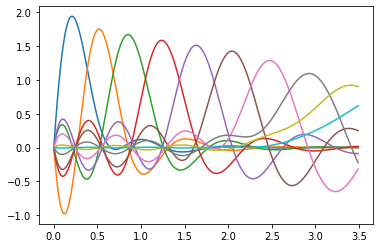

In [14]:
cutoff = 3.5
max_radial = hypers_ps["max_radial"]
grid = np.arange(0, cutoff, 0.01)
gto_basis = radial_basis_functions_gto(grid, max_radial=max_radial, cutoff=cutoff)
for g in gto_basis:
    plt.plot(grid, g)

In [15]:
gto_basis.shape

(10, 350)

In [16]:
gto_basis_alpha = np.tile(gto_basis,(len(all_species),1))
gto_basis_alpha.shape

(40, 350)

In [17]:
new_basis = mat.T @ gto_basis_alpha
new_basis.shape

(10, 350)

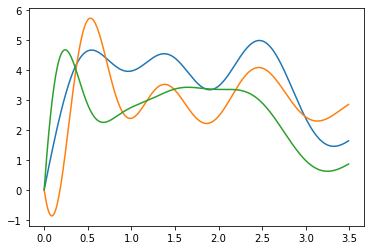

In [18]:
for g in new_basis[:3]:
    plt.plot(grid, g)

In [19]:
new_basis_alpha = [0]*len(all_species)
for i in range(len(all_species)):
    new_basis_alpha[i] = mat[i*max_radial : (i+1)*max_radial].T @ gto_basis
new_basis_alpha = np.array(new_basis_alpha)
new_basis_alpha.shape

(4, 10, 350)

In [20]:
new_basis_alpha = new_basis_alpha.reshape(new_basis_alpha.shape[1], new_basis_alpha.shape[0], -1)
new_basis_alpha.shape

(10, 4, 350)

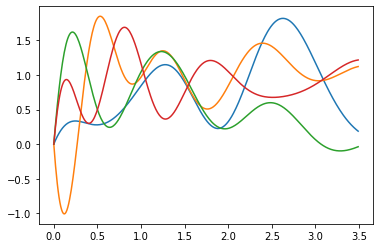

In [21]:
for g in new_basis_alpha[:1]:
    for gg in g[:5]:
        plt.plot(grid, gg)

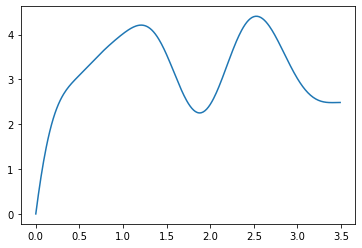

In [22]:
ggg = np.zeros_like(new_basis_alpha[0, 0])
for g in new_basis_alpha[:1]:
    for gg in g:
        ggg+= gg
plt.plot(grid, ggg)

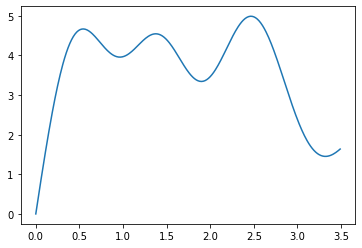

In [23]:
for g in new_basis[:1]:
    plt.plot(grid, g)